In [104]:
import zipfile
import os
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()


Saving SpamData.zip to SpamData.zip


In [9]:
zip_file = 'SpamData.zip'
unzip_dir = '/content/DataExtracted'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [10]:
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content


**Constants**

In [50]:
EXAMPLE_FILE = 'DataExtracted/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'DataExtracted/SpamData/01_Processing/email-text-data.json'

**Generator Functions**

In [18]:
def generate_squares(N):
  for my_number in range(N):
    yield my_number ** 2

In [19]:
for i in generate_squares(5):
  print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

**Email body extraction**

In [25]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:

      filepath = join(root, file_name)
      stream = open(filepath, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == '\n':
          is_body = True

      stream.close()
      email_body = '\n'.join(lines)

      yield file_name, email_body

In [21]:
def df_from_directory(path,classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)


  return pd.DataFrame(rows, index=row_names)

In [26]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, 1)])
spam_emails.head()

,MESSAGE,CATEGORY
00201.00020fc9911604f6cae7ae0f598ad29d,<html>\n\n\n\n\n\n\n\n<body>\n\n\n\n<div align...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00069.066b1a012235d062a5da73eead4a6b35,#############################################...,1
00117.b3ceb6525a1dc935463f3e3080110039,SUBSTANTIAL MONTHLY INCOME MAKERS VOUCHER\n\nI...,1
00163.244a217b150d2129cbdc52b96d992382,We guarantee you signups before you ever pay\n...,1


In [27]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, 0)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, 0)])
ham_emails.shape

(3901, 2)

In [28]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire DataFrame is:', data.shape)
data.head()

Shape of entire DataFrame is: (5799, 2)


,MESSAGE,CATEGORY
00201.00020fc9911604f6cae7ae0f598ad29d,<html>\n\n\n\n\n\n\n\n<body>\n\n\n\n<div align...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00069.066b1a012235d062a5da73eead4a6b35,#############################################...,1
00117.b3ceb6525a1dc935463f3e3080110039,SUBSTANTIAL MONTHLY INCOME MAKERS VOUCHER\n\nI...,1
00163.244a217b150d2129cbdc52b96d992382,We guarantee you signups before you ever pay\n...,1


In [29]:
data.tail()

,MESSAGE,CATEGORY
00391.5fc0c6810ac42e66c4dcc7d6524dd596,"> Of course, it would require a minimum of EUR...",0
00729.733ee0faa56c33c52cb73337b7986261,> There are so many good musician jokes.\n\n\n...,0
00463.a0b9bc6f874e76510933906b72baae3f,No problems installing OpenOffice 653??? and 1...,0
00941.7e73d0b5d1de68eabc52c3e8d05349d8,"On Wed, 2002-07-31 at 15:16, Elias Sinderson w...",0
00072.198398984661d0b6dc676ad30d6f2884,"| Date: Fri, 19 Jul 2002 16:15:49 +0100\n\n ...",0


**Data Cleaning: Checking for missing values**

In [30]:
#Check if any message bodies are null
#data.MESSAGE
#second option
data['MESSAGE'].isnull().values.any()


False

In [31]:
#check if there are empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [32]:
(data.MESSAGE.str.len() == 0).sum()

3

In [33]:
data.MESSAGE.isnull().sum()

0

**Locate empty emails**

In [34]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [35]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [36]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

**Remove System File Entries from Dataframe**

In [39]:
data.drop(['cmds'], inplace=True)


,MESSAGE,CATEGORY
01274.0d083a2d3b30061efdc2cc73ee9e76e3,<a href=http://www.aaronsw.com/weblog/>\n\nAar...,0
00799.43fc9562e5a55f83f0ff75fd648bbe87,\n\nSo whats the eariliest for hitting 7k?\n\...,0
00843.b26541d28a2a01ed3f2e9e5597ea321d,funny load message:\n\nmoo!moo!moo!moo!moo!moo...,0


In [40]:
data.shape

(5796, 2)

In [37]:
type(data)


pandas.core.frame.DataFrame

**Add Document Ids to track emails in dataset**

In [43]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids


In [44]:
data.DOC_ID

,DOC_ID
00201.00020fc9911604f6cae7ae0f598ad29d,0
00210.050ffd105bd4e006771ee63cabc59978,1
00069.066b1a012235d062a5da73eead4a6b35,2
00117.b3ceb6525a1dc935463f3e3080110039,3
00163.244a217b150d2129cbdc52b96d992382,4
...,...
00391.5fc0c6810ac42e66c4dcc7d6524dd596,5791
00729.733ee0faa56c33c52cb73337b7986261,5792
00463.a0b9bc6f874e76510933906b72baae3f,5793
00941.7e73d0b5d1de68eabc52c3e8d05349d8,5794


In [47]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,<html>\n\n\n\n\n\n\n\n<body>\n\n\n\n<div align...,1,00201.00020fc9911604f6cae7ae0f598ad29d
1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
2,#############################################...,1,00069.066b1a012235d062a5da73eead4a6b35
3,SUBSTANTIAL MONTHLY INCOME MAKERS VOUCHER\n\nI...,1,00117.b3ceb6525a1dc935463f3e3080110039
4,We guarantee you signups before you ever pay\n...,1,00163.244a217b150d2129cbdc52b96d992382


In [49]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"> Of course, it would require a minimum of EUR...",0,00391.5fc0c6810ac42e66c4dcc7d6524dd596
5792,> There are so many good musician jokes.\n\n\n...,0,00729.733ee0faa56c33c52cb73337b7986261
5793,No problems installing OpenOffice 653??? and 1...,0,00463.a0b9bc6f874e76510933906b72baae3f
5794,"On Wed, 2002-07-31 at 15:16, Elias Sinderson w...",0,00941.7e73d0b5d1de68eabc52c3e8d05349d8
5795,"| Date: Fri, 19 Jul 2002 16:15:49 +0100\n\n ...",0,00072.198398984661d0b6dc676ad30d6f2884


**Save to file using Pandas**

In [52]:
data.to_json(DATA_JSON_FILE)

**Number of spam messages visualised**

In [53]:
data.CATEGORY.value_counts()

,count
CATEGORY,
0,3900
1,1896


In [58]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
print('Amount of spam messages:', amount_of_spam)
print('Amount of ham messages:', amount_of_ham)

Amount of spam messages: 1896
Amount of ham messages: 3900


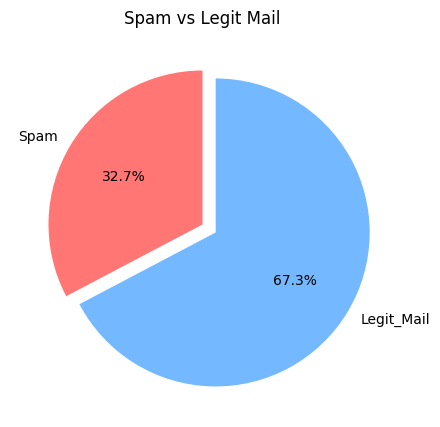

In [ ]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, explode=[0, 0.1])
plt.title('Spam vs Legit Mail')
plt.show()

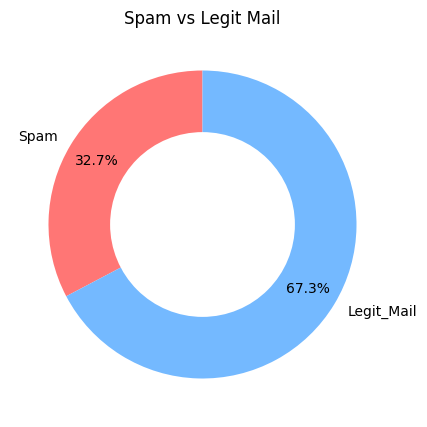

In [82]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

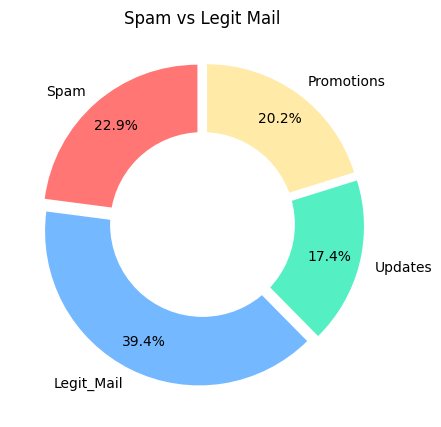

In [86]:
category_names = ['Spam', 'Legit_Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
offset = [0.05, 0.05, 0.05, 0.05]

custom_colors = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

# **Natural Language Processing**
**Text Pre-Processing**

In [87]:
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

**Download the NLTK Resources(Tokenizer & Stopwords)**

In [90]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [93]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Tokenising**

In [92]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

**Removing stop words**

In [98]:
stop_words = set(stopwords.words('english'))

In [100]:
if 'this' in stop_words:
  print('True')
else:
  print('Nope.Not in here')

Nope.Not in here


In [102]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question']


**Word Stems and Stemming**

In [105]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question. \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.', 'nobody', 'expects', 'spanish', 'inquisition']


In [107]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.??? \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
  if word not in stop_words and word.isalpha():
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'nobody', 'expects', 'spanish', 'inquisition']
